In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tools
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer,Imputer,OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from collections import defaultdict
from sklearn_pandas import gen_features,DataFrameMapper, CategoricalImputer

%matplotlib inline

Using TensorFlow backend.


## Loading the dataset

In [3]:
train = pd.read_csv("https://datahack-prod.s3.amazonaws.com/train_file/train_u6lujuX_CVtuZ9i.csv")
test = pd.read_csv("https://datahack-prod.s3.amazonaws.com/test_file/test_Y3wMUE5_7gLdaTN.csv")

## Copying the dataset

In [18]:
train_original = train.copy()
test_original = test.copy()

---

## Quick Data Exploration

### View first 10 rows

In [5]:
train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


### Structure

#### Dataset

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


It can be infer from the above output that all the variables of type non-null object except Loan_ID should be converted to category type. The shape of the data set is:

In [7]:
train.shape

(614, 13)

#### Test

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


`Test` doesn't contain loan_status variable and null values are present there in the dataset. The shape of the dataset is:

In [9]:
test.shape

(367, 12)

### Category types

In [10]:
cat_var_list = ['Gender','Married','Dependents','Education','Self_Employed',
                'Credit_History','Property_Area','Loan_Status']

Following are the variables of category types:
1. Gender
2. Married
3. Dependents
4. Education
5. Self_Employed
6. Property_Area
7. Loan_Status
8. Credit_History

### Summary

In [11]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Following are the few inference made from the above Output:
1. Loan Amount has 22 missing values.
2. Loan Amount Term has 14 missing values.
3. Credit History has 50 missing values.
4. It can also be seen from the credit history that 84% of the people have credit_history.

### Non-Numeric Values

#### Counts

In [12]:
train[cat_var_list].count()

Gender            601
Married           611
Dependents        599
Education         614
Self_Employed     582
Credit_History    564
Property_Area     614
Loan_Status       614
dtype: int64

#### Unique Values

In [13]:
for col in cat_var_list:
    print(col+":",train[col].unique())

Gender: ['Male' 'Female' nan]
Married: ['No' 'Yes' nan]
Dependents: ['0' '1' '2' '3+' nan]
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes' nan]
Credit_History: [ 1.  0. nan]
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: ['Y' 'N']


Following are the few inferences made from the Output:
1. Gender has 13 missing values.
2. Married has 3 missing values.
3. Dependants has 15 missing vlaues.
4. Self_Employed has 31 missing values.
5. Credit_History has 50 missing values.

---

## Distibution Analysis

In [14]:
def dist_plot(df,col_name):
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    sns.distplot(df[col_name].dropna(),ax=axes[0])
    axes[0].set_title("Histogram")
    axes[0].set_xlabel(col_name)
    df.boxplot(col_name,ax=axes[1])
    axes[1].set_title("BoxPlot")
    plt.show()
    df.boxplot(col_name,by="Loan_Status")
    plt.title("")
    plt.ylabel(col_name)

In [15]:
def boxplot_variable(df,col_name):
    l = len(cat_var_list)
    rows,cols = math.ceil(l/2),2
    fig,axes = plt.subplots(rows,cols,figsize=(13,21))
    i,j=0,0
    for col in cat_var_list:
        if j == cols:
            j = 0
            i+=1
        df.boxplot(column=col_name,by=col,ax=axes[i][j])
        axes[i][j].set_title("BoxPlot Grouped By " + col)
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel(col_name)
        j+=1
    fig.suptitle("")
    plt.show()
    

### Applicant Income

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



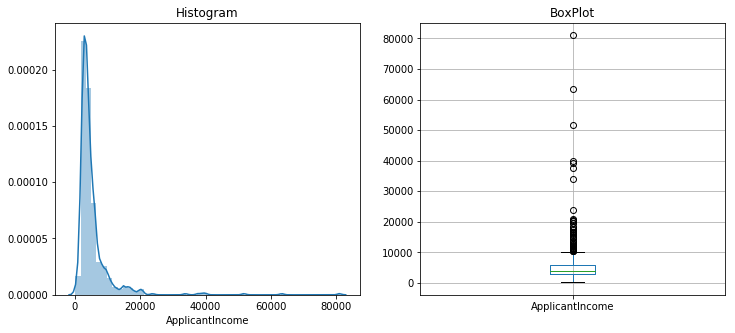

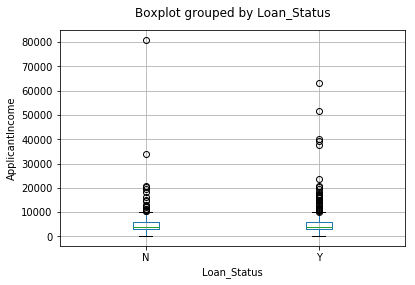

In [16]:
dist_plot(train,"ApplicantIncome")

As it can be seen that there are a few extreme values and the distribution is right skewed and from the boxplot it can also be seen that there are extreme values. It can be due to income disparity in the society. It may be due to difference in education levels.

#### Boxplot by Education

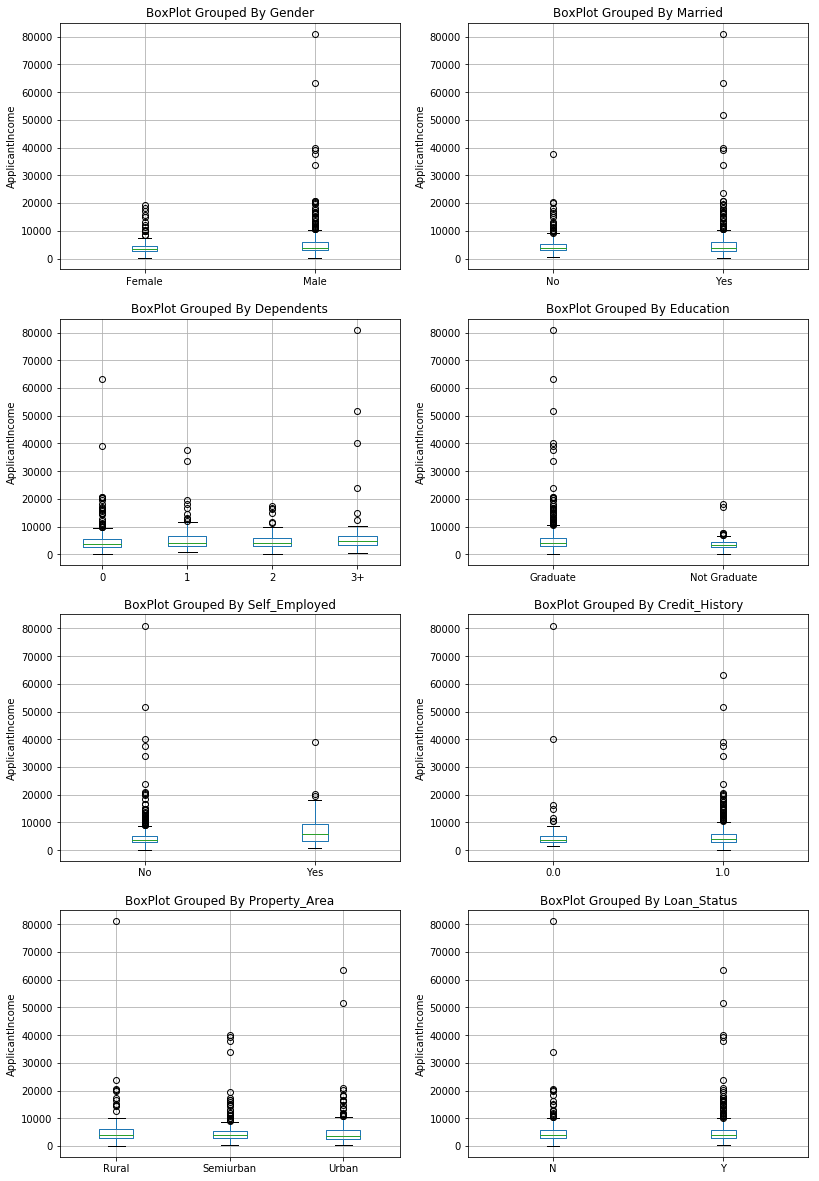

In [17]:
boxplot_variable(train,"ApplicantIncome")

From the above plots we can make the following inference:
1. **Gender** seems to have no effect on applicant income.
2. **Married** seems to have no effect on applicant income.
3. The applicant with 0 **Dependents** seem to have many outlier while the outlier with largest income has 3+ dependents.
4. **Education** seems to affect the applicant income. The graduate and not gradute have different medians and higher number gradurate people have higher income which seems to be outliers.
5. The median of income of **Self-Employed** is higher than the people who are not self employed but the people who are not self employed have higher number of outliers.
6. Applicant having **Credit_History** usually have higher income.
7. People having **Property_Area** in Urban Areas seem to have higher income.
8. **Loan_Status** seems to have very little effect on applicant income. Large number of people are their in the group giving the loan. But it may be due to fact that proportion of both types is not the same.

### Coapplicant Income

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



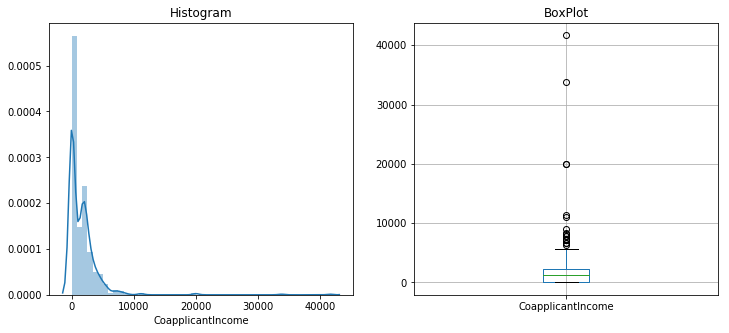

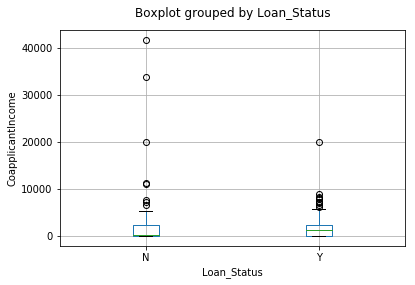

In [18]:
dist_plot(train,"CoapplicantIncome")

As it can be seen that there are a few extreme values and the distribution is right skewed and from the boxplot it can also be seen that indeed there are extreme values. It can be due to income disparity in the society. This variable depends upon the applicant so it does not need to be addressed further.

### LoanAmount

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



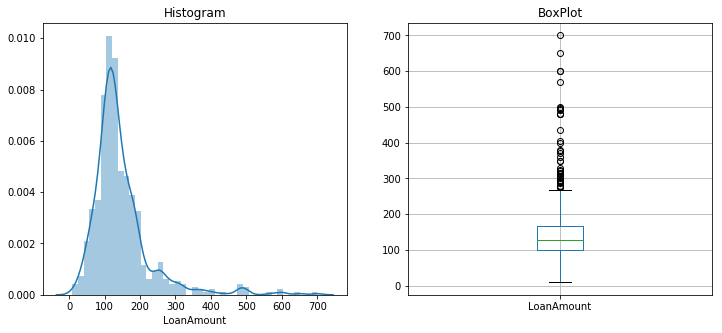

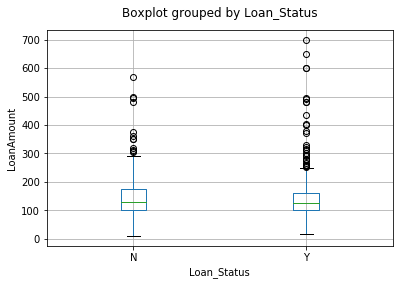

In [19]:
dist_plot(train,"LoanAmount")

As it can be seen that the data is little bit right skewed. The boxplot also confirms the skewness and outliers in the distribution. While the "ApplicantIncome" needs some processing to remove skewness we also need to impute LoanAmount to remove the null values and also to remove its skewness.

---

## Categorical Variables

In [20]:
def plot_bars(df,var,cat_var):
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    
    df[var].value_counts().plot(kind="bar",ax=axes[0])
    
    axes[0].set_ylabel("count")
    axes[0].set_title("Bar Plot of " + var )
    axes[0].set_xticklabels(df[var].unique(),rotation=0)
    
    freq_tab = pd.crosstab(df[var],df[cat_var])
    sum_freq = freq_tab.sum(axis=1)
    prop_tb = freq_tab.divide(sum_freq,axis=0)
    prop_tb.plot(kind="bar",stacked=True,color=['red','green'],ax=axes[1])
    
    axes[1].set_ylim(0,1.27)
    axes[1].set_xticklabels(list(prop_tb.index),rotation=0)
    axes[1].set_ylabel("Proportion")
    axes[1].set_title("Bar Plot of " + var +" proportion by " + cat_var)
    
    print(freq_tab)
    plt.show()

### Gender

Loan_Status    N    Y
Gender               
Female        37   75
Male         150  339


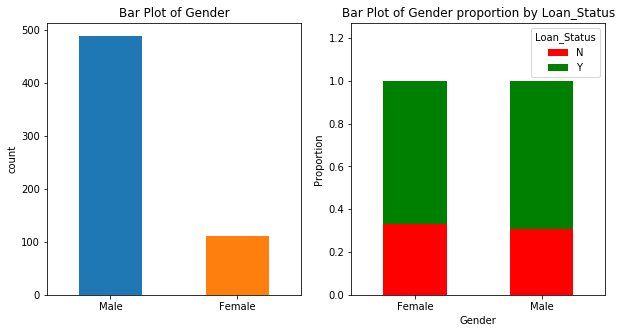

In [21]:
plot_bars(train,"Gender","Loan_Status")

As it can be seen that even if both genders have different applicants but the proportion of acceptance is nearly the same.  

### Married

Loan_Status    N    Y
Married              
No            79  134
Yes          113  285


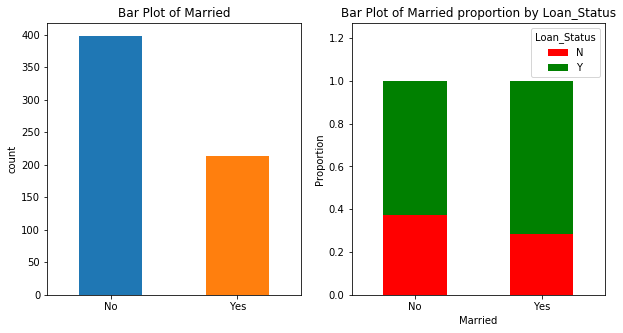

In [22]:
plot_bars(train,"Married","Loan_Status")

It can be seen that from the plots that married people have 10% better chance in getting loan.

### Dependents

Loan_Status    N    Y
Dependents           
0            107  238
1             36   66
2             25   76
3+            18   33


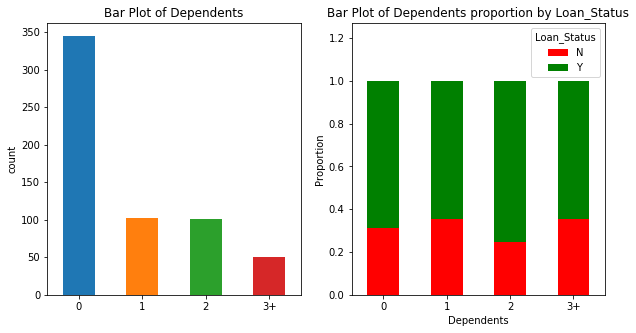

In [23]:
plot_bars(train,"Dependents",'Loan_Status')

### Education

Loan_Status     N    Y
Education             
Graduate      140  340
Not Graduate   52   82


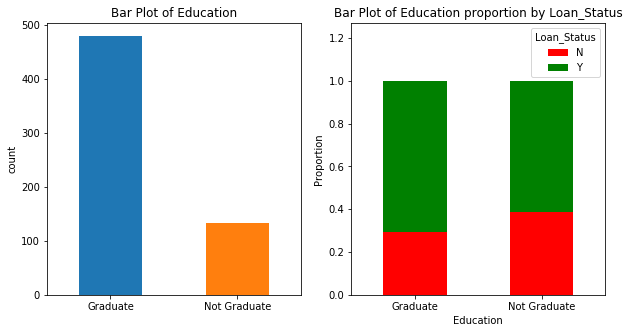

In [24]:
plot_bars(train,"Education","Loan_Status")

From the plot we can infer that Graduate applicant have approximately 10 % better chance in getting Loan.

### Self_Employed

Loan_Status      N    Y
Self_Employed          
No             157  343
Yes             26   56


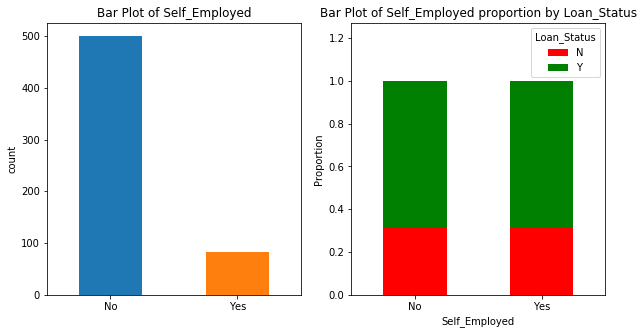

In [25]:
plot_bars(train,"Self_Employed","Loan_Status")

Self_Employment seems to have no effect on getting loan accepted.

### Credit_History

Loan_Status      N    Y
Credit_History         
0.0             82    7
1.0             97  378


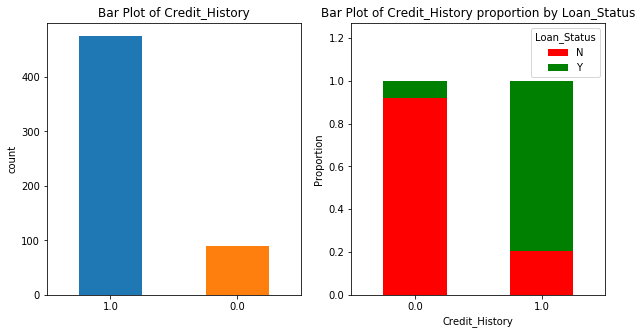

In [26]:
plot_bars(train,"Credit_History","Loan_Status")

It can be seen from the plots that the applicant with good credit history have approximate 80% chance of getting loan while bad credit history implies less than 10% loan acceptance irrespective of the credit hisotry distribution.

### Property_Area

Loan_Status     N    Y
Property_Area         
Rural          69  110
Semiurban      54  179
Urban          69  133


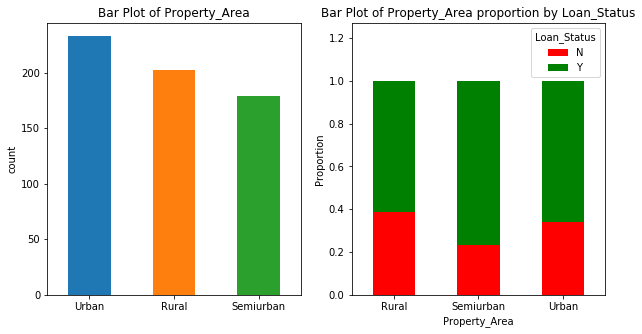

In [27]:
plot_bars(train,"Property_Area","Loan_Status")

From the barplots it can be infered that applicant with property in semiurban have the best change in getting loan.

### Combination of Variables

In [28]:
def plot_bar_cross(df,var_list,cat_var):
    t = df.groupby(var_list).Loan_Status.value_counts().unstack()
    prop_tb = t.divide(t.sum(axis=1),axis=0)
    
    prop_tb.plot(kind="bar",stacked=True,color=['red','green'])
    plt.ylim((0,1.4))
    plt.xticks(rotation=0)
    plt.ylabel("Proportion")
    plt.title("Bar Plot of " + str(var_list) +" proportion by " + cat_var)
    plt.show()

#### Credit_History and Gender

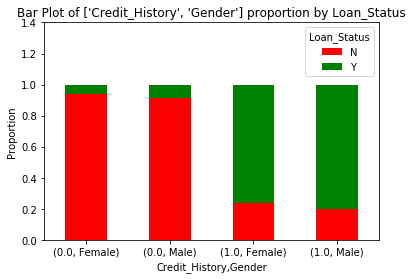

In [29]:
plot_bar_cross(train,['Credit_History','Gender'],'Loan_Status')

This plot shows that male applicants have slighly better chance in getting loan irrespective of their Credit_History. 

#### Credit_History and Married

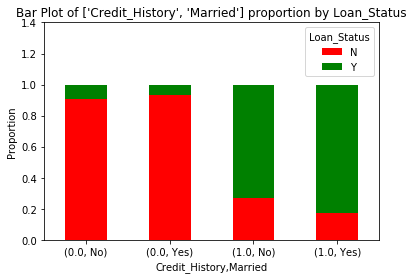

In [30]:
plot_bar_cross(train,['Credit_History','Married'],'Loan_Status')

From the plot we can infere the following:
1. UnMarried applicant has slightly better chance in getting loan if he has no credit history.
2. Married applicant has slightly better chance in getting loan if he has good credit history.

#### Credit_History and Education

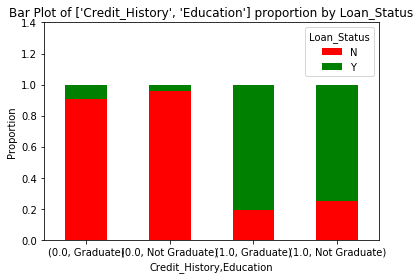

In [31]:
plot_bar_cross(train,['Credit_History','Education'],'Loan_Status')

It can be seen that graduate applicant has better chance in getting loan irrespective of his credit history.

## Correlation

In [32]:
# replacing 3+ in Dependents variable with 3
# replacing Y and N in Loan_Status variable with 1 and 0 respectively
train['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)
test['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)

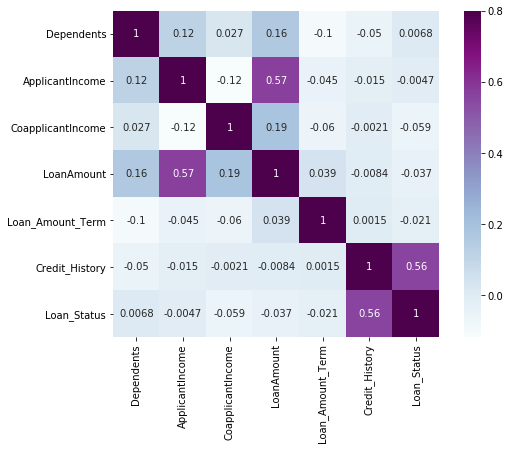

In [33]:
matrix = train.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu",annot=True);

---

## Without Using Pipeline

### Data Munging

### Imputing Manually

#### Numerical Variables

In [34]:
def impute_numeric(df):
    numeric_cols = ['ApplicantIncome','LoanAmount','CoapplicantIncome']
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df
train = impute_numeric(train)
test = impute_numeric(test)

#### Categorical Variables

In [35]:
def impute_categorical(df):
    categorical_cols = ['Gender','Married','Dependents','Education','Self_Employed',
                        'Credit_History','Property_Area']

    for col in categorical_cols+['Loan_Amount_Term']:
        df[col].fillna(df[col].mode()[0],inplace=True)
    return df

train = impute_categorical(train)
test = impute_categorical(test)

In [36]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [37]:
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

### Removing Skewness by Logarithmic Transformation

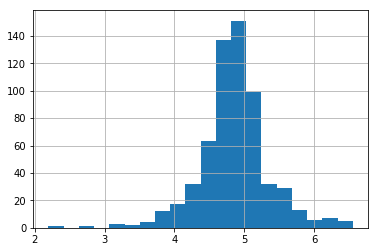

In [38]:
train['LoanAmount_log'] = np.log(train.LoanAmount)
train['LoanAmount_log'].hist(bins=20)
test['LoanAmount_log'] = np.log(test.LoanAmount)

### Dropping Loan_ID Column

In [39]:
train=train.drop('Loan_ID',axis=1)
test=test.drop('Loan_ID',axis=1)

### Spliiting into X and Y

In [40]:
X = train.drop('Loan_Status',1)
y = train.Loan_Status

### Creating Dummy Variables

In [41]:
# Adding dummies to the dataset
X=pd.get_dummies(X,drop_first=True)
train=pd.get_dummies(train,drop_first=True)
test=pd.get_dummies(test,drop_first=True)

### Helper Functions

#### Model Train KFolds
trains the model by KFolds

In [42]:
def model_train_kfolds(model,X,y,test,n_splits=5):
    i=1
    kf = StratifiedKFold(n_splits=n_splits,random_state=1,shuffle=True)
    for train_index,test_index in kf.split(X,y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = y[train_index],y[test_index]

        model.fit(xtr, ytr)
        pred_test = model.predict(xvl)
        score = accuracy_score(yvl,pred_test)
        print('accuracy_score',score)
        i+=1
    model.fit(X,y)
    pred_test = model.predict(test)
    return pred_test

#### Create submission File
A helper function to create submission file.

In [43]:
# Read submission file
submission=pd.read_csv("https://datahack-prod.s3.amazonaws.com/sample_submission/Sample_Submission_ZAuTl8O_FK3zQHh.csv")

def create_submission(pred_test,name):
    submission['Loan_Status']=pred_test
    submission['Loan_ID']=test_original['Loan_ID']
    submission['Loan_Status'].replace(0, 'N',inplace=True)
    submission['Loan_Status'].replace(1, 'Y',inplace=True)
    pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv(name+'.csv',index=False)

### Logistic Regression

In [44]:
# logistic regression
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]

    model = LogisticRegression(random_state=1)
    model.fit(xtr, ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print('accuracy_score',score)
    i+=1
pred_test = model.predict(test)
pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.7983870967741935

2 of kfold 5
accuracy_score 0.8306451612903226

3 of kfold 5
accuracy_score 0.8114754098360656

4 of kfold 5
accuracy_score 0.7950819672131147

5 of kfold 5
accuracy_score 0.8278688524590164


#### ROC

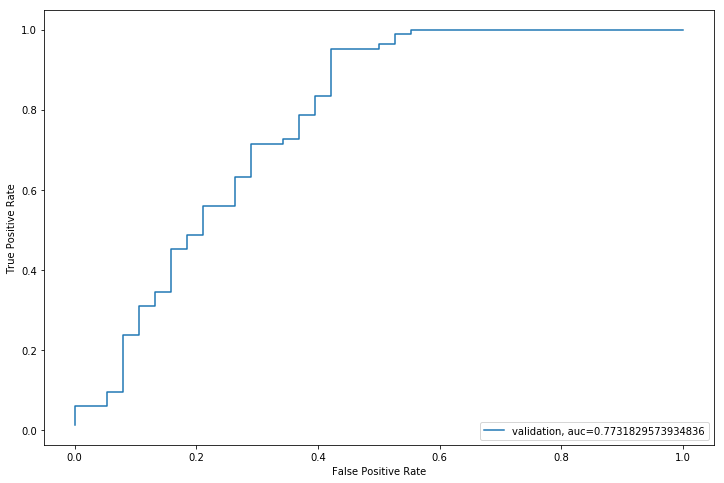

In [45]:
# ROC curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(yvl,  pred)
auc = metrics.roc_auc_score(yvl, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [46]:
# Converting submission file to .csv format
create_submission(pred_test,"Logistic.csv")

This submission got 0.77778 score

### Feature Engineering

In [47]:
train.columns

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'LoanAmount_log',
       'Gender_Male', 'Married_Yes', 'Education_Not Graduate',
       'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

In [48]:
# Total_Income feature
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



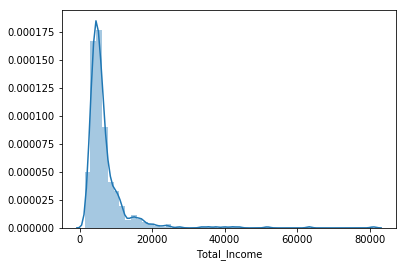

In [49]:
sns.distplot(train['Total_Income']);

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



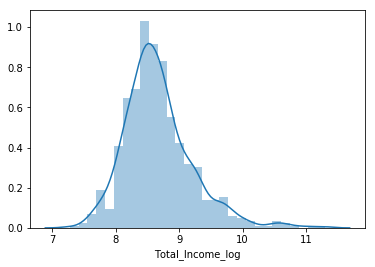

In [50]:
train['Total_Income_log'] = np.log(train['Total_Income'])
sns.distplot(train['Total_Income_log']);
test['Total_Income_log'] = np.log(test['Total_Income'])

In [51]:
# EMI feature
train['EMI']=(train['LoanAmount']/train['Loan_Amount_Term'])*1000
test['EMI']=(test['LoanAmount']/test['Loan_Amount_Term'])*1000

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



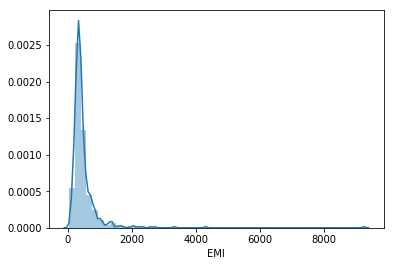

In [52]:
sns.distplot(train['EMI']);

In [53]:
# Balance Income feature
train['Balance Income']=train['Total_Income']-(train['EMI']) 
test['Balance Income']=test['Total_Income']-(test['EMI'])

C:\Users\naqee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



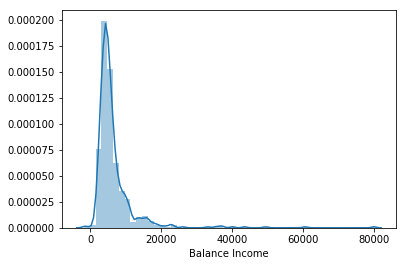

In [54]:
sns.distplot(train['Balance Income']);

### Splitting into X and y

In [55]:
X = train.drop('Loan_Status',1)
y = train.Loan_Status                # Save target variable in separate dataset

### Logistic Regression

In [56]:
model = LogisticRegression(random_state=1)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.7983870967741935

2 of kfold 5
accuracy_score 0.8306451612903226

3 of kfold 5
accuracy_score 0.8114754098360656

4 of kfold 5
accuracy_score 0.7786885245901639

5 of kfold 5
accuracy_score 0.8278688524590164


In [57]:
create_submission(pred_test,"log2")

From this submission we got an accuracy of 0.7847 on the leaderboard.

### Decission Tree

In [58]:
from sklearn import tree

In [59]:
model = tree.DecisionTreeClassifier(random_state=1)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.6612903225806451

2 of kfold 5
accuracy_score 0.7258064516129032

3 of kfold 5
accuracy_score 0.680327868852459

4 of kfold 5
accuracy_score 0.7295081967213115

5 of kfold 5
accuracy_score 0.7213114754098361


In [60]:
create_submission(pred_test,"decission_tree")

We got an accuracy of 0.659 which is much lesser than the accuracy from logistic regression model.

### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
model = RandomForestClassifier(random_state=1, max_depth=10)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.782258064516129

2 of kfold 5
accuracy_score 0.8145161290322581

3 of kfold 5
accuracy_score 0.7377049180327869

4 of kfold 5
accuracy_score 0.7868852459016393

5 of kfold 5
accuracy_score 0.819672131147541


In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
# Provide range for max_depth from 1 to 20 with an interval of 2 and from 1 to 200 with an interval of 20 for n_estimators
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}

In [65]:
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid,n_jobs=-1,cv=5)

In [66]:
# Fit the grid search model
grid_search.fit(X,y)

# Estimating the optimized value
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [67]:
model = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=1)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.782258064516129

2 of kfold 5
accuracy_score 0.8064516129032258

3 of kfold 5
accuracy_score 0.7786885245901639

4 of kfold 5
accuracy_score 0.7950819672131147

5 of kfold 5
accuracy_score 0.8442622950819673


In [68]:
create_submission(pred_test,"random_forest")

We got an accuracy of 0.763 from random forest model.

### XGBoost

In [69]:
from xgboost import XGBClassifier

In [70]:
model = XGBClassifier(n_estimators=50, max_depth=4)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.7983870967741935

2 of kfold 5
accuracy_score 0.8145161290322581

3 of kfold 5


C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



accuracy_score 0.7786885245901639

4 of kfold 5
accuracy_score 0.7950819672131147

5 of kfold 5
accuracy_score 0.819672131147541


C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [71]:
create_submission(pred_test,"xgboost")

We got an accuracy of 0.7778 from XGBoost model

### Linear SVC

In [72]:
from sklearn.svm import LinearSVC

In [73]:
model = LinearSVC(random_state=1)
pred_test = model_train_kfolds(model,X,y,test)


1 of kfold 5
accuracy_score 0.6854838709677419

2 of kfold 5
accuracy_score 0.6774193548387096

3 of kfold 5
accuracy_score 0.6885245901639344

4 of kfold 5
accuracy_score 0.680327868852459

5 of kfold 5
accuracy_score 0.7049180327868853


In [74]:
create_submission(pred_test,"LinearSVC")

Accuracy 0.284

### KNeighbours

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knnClassifer = KNeighborsClassifier(n_neighbors=20)
pred_test = model_train_kfolds(knnClassifer,X,y,test)


1 of kfold 5
accuracy_score 0.6774193548387096

2 of kfold 5
accuracy_score 0.6774193548387096

3 of kfold 5
accuracy_score 0.6885245901639344

4 of kfold 5
accuracy_score 0.6639344262295082

5 of kfold 5
accuracy_score 0.6475409836065574


In [77]:
create_submission(pred_test,"KNeighbors")

Accuracy is 0.6805

### SVM

In [78]:
from sklearn import svm, grid_search

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [79]:
def scv_param_selection(X,y,nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['rbf','sigmoid']
    param_grid = {'C':Cs,'kernel':kernels,'gamma':gammas}
#     param_grid = {'kernel':kernels}
    grid_search = GridSearchCV(svm.SVC(),param_grid,cv=nfolds)
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

In [80]:
scv_param_selection(X,y,10)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [81]:
svm_model = svm.SVC(C=1,gamma=0.001,kernel='rbf')
pred_test = model_train_kfolds(svm_model,X,y,test)


1 of kfold 5
accuracy_score 0.6935483870967742

2 of kfold 5
accuracy_score 0.6854838709677419

3 of kfold 5
accuracy_score 0.6967213114754098

4 of kfold 5
accuracy_score 0.7049180327868853

5 of kfold 5
accuracy_score 0.6885245901639344


In [82]:
create_submission(pred_test,"SVC")

The accuracy is 0.7152

## Pipeline

### Simple Pipeline without Feature Engineering

#### Original Data

In [83]:
train = train_original.copy()
test = test_original.copy()

In [84]:
mean_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
categorical_cols = ['Gender','Married','Dependents','Education',
                    'Self_Employed','Credit_History',
                    'Property_Area'
                   ]

#### Feature Extraction Function, Imputer and MutiColumn Encoders

In [85]:
def get_mean_cols(X):
    return X[mean_cols]

def get_loan_amount_term(X):
    return X[['Loan_Amount_Term']]

def get_categorical_cols(X):
    return X[categorical_cols]

class ModeImputer(TransformerMixin,BaseEstimator):
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0] for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

class MeanImputer(TransformerMixin,BaseEstimator):
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
class MultiColumnLabelEncoder(TransformerMixin,BaseEstimator):  
    """Transformer for applying label encoder on multiple columns.

    This transformer applies label encoding to columns in a dataset.
    """

    def __init__(self):
        self.d = defaultdict(LabelEncoder)

    def transform(self, X, **transform_params):
        """Transforms X to have columns label encoded.

        Args:
            X (obj): The dataset to transform. Can be dataframe or matrix.
            transform_params (kwargs, optional): Additional params.

        Returns:
            The transformed dataset with the label encoded columns.
        """
        X = X.fillna('NaN')  # fill null values with 'NaN'
        transformed = X.apply(lambda x: self.d[x.name].transform(x))
        return transformed

    def fit(self, X, y=None, **fit_params):
        """Fits transfomer over X.

        Needs to apply fit over the defaultdict so as to retain the
        label classes when transforming.
        """
        X = X.fillna('NaN')  # fill null values with 'NaN'
        X.apply(lambda x: self.d[x.name].fit(x))
        return self

#### Transformation Pipeline

##### Helper Function

In [301]:
def create_transformation_pipeline(numeric_features_pipeline):
    
    numeric_pipeline = Pipeline([
                            ('numeric_cols',numeric_features_pipeline),
                            ('scaling',StandardScaler())
                        ])

    categorical_pipeline = Pipeline([
                                ('cat_selection',FunctionTransformer(get_categorical_cols,validate=False)),
                                ('impute_mode',ModeImputer()),
                                ('Encoder',MultiColumnLabelEncoder()),
                                ('OneHotEncoder',OneHotEncoder())
    ])

    transformation_pipeline = FeatureUnion([
                                    ('numeric_pipeline',numeric_pipeline),
                                    ('categorical_pipeline',categorical_pipeline)
                                ])
    
    return transformation_pipeline

##### Creating Numeric Feature Pipeline

In [302]:
mean_impute_pipeline = Pipeline([
                            ('mean_cols',FunctionTransformer(get_mean_cols,validate=False)),
                            ('impute_mean',Imputer())
                        ])
impute_loan_term = Pipeline([
                        ('loan_term_cols',FunctionTransformer(get_loan_amount_term,validate=False)),
                        ('impute_frequent',Imputer(strategy="most_frequent"))
                    ])
numeric_features_pipeline = FeatureUnion([('mean_impute_pipeline',mean_impute_pipeline),
                            ('impute_loan_term',impute_loan_term)
                            ])


##### Creating Transformation Pipeline

In [303]:
transformation_pipeline = create_transformation_pipeline(numeric_features_pipeline)

#### Estimators

In [89]:
models_dict = {"Logistic_Regression":LogisticRegression(random_state=1),
               "Decission_Tree":tree.DecisionTreeClassifier(),
               "XGBoost":XGBClassifier(n_estimators=50, max_depth=4),
               "Linear_SVC":LinearSVC(random_state=1),
               "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=20),}

#### Optimizing Hyper Parameters

##### Helper Functions

**Random Forest**

In [90]:
def get_opt_prams_rf(transformation_pipeline):
    pipeline_rf = Pipeline([
                ('Transformation_pipeline',transformation_pipeline),
                ("Random_Forest",RandomForestClassifier(random_state=1))
    ])

    paramgrid = {'Random_Forest__max_depth': list(range(1, 20, 2)),
                 'Random_Forest__n_estimators': list(range(1, 200, 20))}

    gridSearchCV = GridSearchCV(pipeline_rf,paramgrid)
    gridSearchCV.fit(train,train.Loan_Status)

    return gridSearchCV.best_params_

**SVM**

In [91]:
def get_opt_params_svm(transformation_pipeline):
    pipeline_svm = Pipeline([
                ('Transformation_pipeline',transformation_pipeline),
                ("SVM_Classifier",svm.SVC())
    ])

    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['rbf','sigmoid']
    param_grid = {'SVM_Classifier__C':Cs,'SVM_Classifier__kernel':kernels,'SVM_Classifier__gamma':gammas}

    gridSearchCV = GridSearchCV(pipeline_svm,param_grid)
    gridSearchCV.fit(train,train.Loan_Status)

    return gridSearchCV.best_params_

##### Random Forest

In [92]:
get_opt_prams_rf(transformation_pipeline)

{'Random_Forest__max_depth': 1, 'Random_Forest__n_estimators': 41}

In [93]:
models_dict["Random_Forest"] = RandomForestClassifier(random_state=1,max_depth=1,n_estimators=41)

##### SVM

In [94]:
get_opt_params_svm(transformation_pipeline)

{'SVM_Classifier__C': 10,
 'SVM_Classifier__gamma': 0.001,
 'SVM_Classifier__kernel': 'rbf'}

In [95]:
models_dict["SVM_Classifier"] = svm.SVC(C=10,gamma=0.001,kernel='rbf')

#### Final Pipeline, fitting and Submission Creation

##### Helper Function

In [96]:
def create_pipelines_list(transformation_pipeline,prefix=""):
    pipeline_models_list = dict()
    for model_name,model in models_dict.items():
        pipeline = Pipeline([
                    ('Transformation_pipeline',transformation_pipeline),
                    (model_name,model)
        ])

        pipeline.fit(train,train.Loan_Status)
        pipeline_models_list[model_name] = pipeline
        pred_test = pipeline.predict(test)
        create_submission(pred_test,prefix+"_pipelined_"+model_name)
        print("Training Accuracy of "+model_name + " is "+str(accuracy_score(pipeline.predict(train),train.Loan_Status)))
    return pipeline_models_list

##### Get Models

In [97]:
pipeline_models_list = create_pipelines_list(transformation_pipeline)

Training Accuracy of Logistic_Regression is 0.8127035830618893
Training Accuracy of Decission_Tree is 1.0


C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Training Accuracy of XGBoost is 0.8501628664495114
Training Accuracy of Linear_SVC is 0.8127035830618893
Training Accuracy of KNeighborsClassifier is 0.7817589576547231
Training Accuracy of Random_Forest is 0.8094462540716613
Training Accuracy of SVM_Classifier is 0.8110749185667753


#### Results
Following are the accuracies which are obtained:
* **Logistic Regression** : 0.7847
* **Decission Tree** : 0.7569
* **Radom Forest** : 0.77778
* **XGBoost** : 0.79166
* **Linear_SVC** : 0.77778
* **SVM_Classisifer** : 0.77778
* **KNeighborsClassifier** : 0.7430

### Feature Engineering

#### Log Transformation Function

In [98]:
def log_col_transformer(X):
    return np.log(X+0.0001)


##### Transformation Pipeline

###### Numeric Features pipeline

In [99]:
mean_impute_log_pipeline = Pipeline([
                            ('mean_cols',FunctionTransformer(get_mean_cols,validate=False)),
                            ('impute_mean',Imputer()),
                            ('Log_Transformation',FunctionTransformer(log_col_transformer,validate=False))
                        ])

impute_loan_term = Pipeline([
                        ('loan_term_cols',FunctionTransformer(get_loan_amount_term,validate=False)),
                        ('impute_frequent',Imputer(strategy="most_frequent"))
                    ])

numeric_features_pipeline = FeatureUnion([('mean_impute_log_pipeline',mean_impute_log_pipeline),
                            ('impute_loan_term',impute_loan_term)
                            ])


###### Creating Transformation pipeline

In [100]:
transformation_pipeline = create_transformation_pipeline(numeric_features_pipeline)

In [101]:
transformation_pipeline.fit_transform(train)

<614x21 sparse matrix of type '<class 'numpy.float64'>'
	with 6754 stored elements in Compressed Sparse Row format>

###### Optimizing Hyper Parameters

###### Random Forest

In [102]:
get_opt_prams_rf(transformation_pipeline)

{'Random_Forest__max_depth': 1, 'Random_Forest__n_estimators': 41}

In [103]:
models_dict["Random_Forest"] = RandomForestClassifier(random_state=1,max_depth=1,n_estimators=41)

###### SVM

In [104]:
get_opt_params_svm(transformation_pipeline)

{'SVM_Classifier__C': 1,
 'SVM_Classifier__gamma': 0.01,
 'SVM_Classifier__kernel': 'rbf'}

In [105]:
models_dict["SVM_Classifier"] = svm.SVC(C=10,gamma=0.001,kernel='rbf')

##### Final Pipeline, fitting and Submission Creation

In [106]:
pipeline_models_list = create_pipelines_list(transformation_pipeline,prefix="log")

Training Accuracy of Logistic_Regression is 0.8110749185667753
Training Accuracy of Decission_Tree is 1.0


C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Training Accuracy of XGBoost is 0.8452768729641694
Training Accuracy of Linear_SVC is 0.8094462540716613
Training Accuracy of KNeighborsClassifier is 0.7687296416938111
Training Accuracy of Random_Forest is 0.8094462540716613
Training Accuracy of SVM_Classifier is 0.8094462540716613


##### Results
Following are the accuracies which are obtained:
* **Logistic Regression** : 0.77778
* **Decission Tree** : 0.708
* **Radom Forest** : 0.77778
* **XGBoost** : 0.8125
* **Linear_SVC** : 0.77778
* **SVM_Classisifer** : 0.77778
* **KNeighborsClassifier** : 0.75694

#### Feature Creation

##### Helper Functions

In [110]:
def total_emi(X):
    total_income = np.log(X['ApplicantIncome'] + X['CoapplicantIncome'] + 0.00001)
    emi = np.log((X['LoanAmount']/X['Loan_Amount_Term']) * 1000 + 0.00001)
    return pd.DataFrame({'total_income' :total_income,'emi':emi,
                         "loan_term":X['Loan_Amount_Term']})

def get_categoricals(X):
    return X.iloc[:,4:]

In [298]:
feature_def = gen_features(
                columns=[['ApplicantIncome'],['CoapplicantIncome'],['LoanAmount']],
                classes=[Imputer]
                ) +\

              gen_features(
                columns=[['Loan_Amount_Term']],
                classes=[Imputer]) +\

              gen_features(
                        columns= [[x] for x in categorical_cols],
                        classes = [CategoricalImputer,LabelBinarizer]
                )

df_impute_encode = DataFrameMapper(feature_def,df_out=True)

numeric_pipeline = Pipeline([('total_emi',FunctionTransformer(total_emi,validate=False)),
                             ('scaling',StandardScaler())
                            ])
transformation_pipeline = Pipeline([('df_impute_encode',df_impute_encode),
                                    ('FeatureUnion',FeatureUnion([
                                        ('numeric_pipeline',numeric_pipeline),
                                        ('get_categorical',FunctionTransformer(get_categoricals,validate=False))
                                        ]))
                                    ])

###### Optimizing Hyper Parameters

###### Random Forest

In [114]:
get_opt_prams_rf(transformation_pipeline)

{'Random_Forest__max_depth': 3, 'Random_Forest__n_estimators': 41}

In [115]:
models_dict["Random_Forest"] = RandomForestClassifier(random_state=1,max_depth=3,n_estimators=41)

###### SVM

In [116]:
get_opt_params_svm(transformation_pipeline)

{'SVM_Classifier__C': 10,
 'SVM_Classifier__gamma': 0.01,
 'SVM_Classifier__kernel': 'rbf'}

In [117]:
models_dict["SVM_Classifier"] = svm.SVC(C=10,gamma=0.01,kernel='rbf')

##### Final Pipeline, fitting and Submission Creation

In [118]:
pipeline_models_list = create_pipelines_list(transformation_pipeline,prefix="total_emi")

Training Accuracy of Logistic_Regression is 0.8094462540716613
Training Accuracy of Decission_Tree is 1.0


C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\naqee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Training Accuracy of XGBoost is 0.8469055374592834
Training Accuracy of Linear_SVC is 0.8094462540716613
Training Accuracy of KNeighborsClassifier is 0.741042345276873
Training Accuracy of Random_Forest is 0.8175895765472313
Training Accuracy of SVM_Classifier is 0.8094462540716613


##### Results
Following are the accuracies which are obtained:
* **Logistic Regression** : 0.77778
* **Decission Tree** : 0.6597
* **Radom Forest** : 0.77778
* **XGBoost** : 0.7874
* **Linear_SVC** : 0.77778
* **SVM_Classisifer** : 0.77778
* **KNeighborsClassifier** : 0.7222

### Deep Learning

In [315]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=16, kernel_initializer=init, activation='relu'))
    model.add(Dense(256, kernel_initializer=init, activation='relu'))
    model.add(Dense(128, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
# split into input (X) and output (Y) variables
# create model
model = KerasClassifier(build_fn=create_model , nb_epoch=200, batch_size=5, verbose=0)

In [316]:
feature_def = gen_features(
                columns=[['ApplicantIncome'],['CoapplicantIncome'],['LoanAmount']],
                classes=[Imputer,StandardScaler]
                ) +\

              gen_features(
                columns=[['Loan_Amount_Term']],
                classes=[Imputer, StandardScaler]) +\

              gen_features(
                        columns= [[x] for x in categorical_cols],
                        classes = [CategoricalImputer,LabelBinarizer]
                )

df_impute_encode = DataFrameMapper(feature_def,df_out=True)

In [317]:
pipeline = Pipeline([('df_impute',df_impute_encode),
                     ('keras_models',model)])

In [319]:
pipeline.fit(train,train.Loan_Status)

Pipeline(memory=None,
     steps=[('df_impute', DataFrameMapper(default=False, df_out=True,
        features=[(['ApplicantIncome'], [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True)]), (['CoapplicantIncome'], [Imputer(axis=0, copy=True, miss...lse)), ('keras_models', <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DC161D89B0>)])

In [321]:
accuracy_score(pipeline.predict(train),train.Loan_Status)

0.8175895765472313

array([[ 0.00846848,  0.07155963,  0.27985054, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.08290346, -0.16696145,  0.27985054, ...,  1.        ,
         0.        ,  0.        ],
       [-1.21736328, -1.3425263 ,  0.27985054, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.65369887,  1.04229516,  0.27985054, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.48516845,  0.50581583,  0.27985054, ...,  0.        ,
         0.        ,  1.        ],
       [-0.43936693, -0.09895424,  0.27985054, ...,  0.        ,
         1.        ,  0.        ]])

In [322]:
pred_test = pipeline.predict(test)

In [323]:
create_submission(pred_test,"sklearn")